<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# EDA with Walmart Sales Data

## Business Objectives

Walmart, the retail giant that operates a chain of hypermarkets, wants to understand their weekly sales data, especially the impact from holidays and or big events on the weekly sales data; specifically, Super Bowl, Labor Day, Thanksgiving, and Christmas. In addition, Walmart wants to consider the effect from different macroeconomic/external factors. 

## Learning Objectives

At the end of this session, you will know how to

1. Manipulate data of different types using `pandas`
1. Visualize data with `matplotlib` and `seaborn` to Extract insights 
1. Build a pipeline to preprocess data and fit a simple model using `sklearn`

*Note: if you see code that's unfamiliar to you, look up for the documentation, and try to understand what it does.*

## Data Overview

- Original sales data were collected from 45 stores across the United States; yet for this session, you will first inspect data from three stores and later focus on just store 1. 

- Each store is of certain type and size, and there are multiple departments in a store. 

- The dataset has a temporal component, we ignore this mostly in this session and will discuss time series related techniques later in the cohort.

In [2]:
!conda env list

# conda environments:
#
base                     /home/cim/anaconda3
py39_12               *  /home/cim/anaconda3/envs/py39_12



In [3]:
!pip install -r ../requirements.txt

In [4]:
# Sanity Check
import numpy as np      
import pandas as pd     

import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # allow multiple outputs in a cell
import warnings
warnings.filterwarnings("ignore")

## Task I: Load Data 

Built on top of `numpy`, `pandas` is one of the tools in machine learning. Its rich features are used for exploring, cleaning, visualizing, and transforming data.  We need to import the library to access all of its features. 

In [6]:
import pandas as pd

Use `pd.read_csv` to read `train_comb.csv` that contains weekly sales, metadata, and macroeconomic features from three stores into a `pd.DataFrame`.

In [7]:
filepath = '../dat/train_comb.csv'
data = pd.read_csv(filepath) 

Verify that the data is loaded correctly by running `data.head(3)` to see the first few row ( AVOID printing out the entire DataFrame, i.e., `data` or `print(data)`; it might be trivial for small dataset but it can crash your kernel when the dataset is big and slow down the initial data exploration process ).

In [8]:
# YOUR CODE HERE
data.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315


In [9]:
print("Date ", data.Date.dtype)
print("Weekly_Sales ", data.Weekly_Sales.dtype)
print("IsHoliday ", data.IsHoliday.dtype)
print("Temperature ", data.Temperature.dtype)
print("Fuel_Price ", data.Fuel_Price.dtype)
print("MarkDown1 ", data.MarkDown1.dtype)
print("CPI ", data.CPI.dtype)
print("Unemployment ", data.Unemployment.dtype)
print("Type ", data.Type.dtype)
print("Size ", data.Size.dtype)
print()
print("Size of data ", data.shape, "\n")
print("data info ", data.info(), "\n")
print("data stats \n", data.describe(), "\n")
# print("Fuel price ", data.Fuel_Price.describe())

Date  object
Weekly_Sales  float64
IsHoliday  bool
Temperature  float64
Fuel_Price  float64
MarkDown1  float64
CPI  float64
Unemployment  float64
Type  object
Size  int64

Size of data  (30990, 16) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30990 entries, 0 to 30989
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         30990 non-null  int64  
 1   Dept          30990 non-null  int64  
 2   Date          30990 non-null  object 
 3   Weekly_Sales  30990 non-null  float64
 4   IsHoliday     30990 non-null  bool   
 5   Temperature   30990 non-null  float64
 6   Fuel_Price    30990 non-null  float64
 7   MarkDown1     11062 non-null  float64
 8   MarkDown2     9260 non-null   float64
 9   MarkDown3     10779 non-null  float64
 10  MarkDown4     10990 non-null  float64
 11  MarkDown5     11062 non-null  float64
 12  CPI           30990 non-null  float64
 13  Unemployment  30990 non-null  float64
 14

Look at the output to get an idea of what each column is and then write a few sentences describing what you notice about the data. You can also use `data.sample(3)` to draw random samples from the data (hints: number of rows and columns, any missing values? data types of the elements? date ranges of the data collected? etc.).


#### Observations:
* The data has 30990 entries with 16 columns. 
* Only about 1/3 of the entries in the "MarkDown(#)" columns are numbers, the rest are 'Nan'. 
* The column values are mostly numbers (continuous float64, and integer int64). 
 * There are two columns 'Date' and 'Type' which are objects. 
 * 'Date' may need to be converted into a DateTime object. 
 * The 'Holiday column is a boolean. 
* Notes on column values:
 * There are 13 stores, 99 departments
 * Somehow weekly sales can be negative (not sure how - did a lot of things get returned?)
 * The temperature is in degrees fahrenheit
 * Gas prices are relatively low compared to today (~\$5\/gallon now)
 * The minimum value in MarkDown2 seems odd
   * -10.5 seems out of place compared to the other columns 
   * How does a negative markdown work - wouldn't that be a price increase?

*Acceptable responses include the number of rows and columns in the dataset, the data types of the elements, how many NaNs there are (and perhaps which columns and/or rows tend to have them), the range of values in each column or other descriptive statistics, some commentary on what this data represents, any initial concerns about how you think we should model this data, or any other commentary you would like to add.*

Use `.shape` to inspect the size of the data: sample size and number of features.

In [10]:
# YOUR CODE HERE
data.shape

(30990, 16)

<details>
<summary>Expected Output</summary>
(30990, 16)
</details>

For the following task, we focus on Store `1` only, 

In [11]:
data_store1 = data[data.Store==1]# YOUR CODE HERE

Retrieve the data from department 9 ( a random choice ) at store 1:

In [12]:
data_store1_dept9 = data_store1[data_store1.Dept == 9] 

Verify the result using `.head()`, `.shape`.

In [13]:
data_store1_dept9.head()
data_store1_dept9.shape

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
1144,1,9,2010-02-05,16930.99,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1145,1,9,2010-02-12,16562.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
1146,1,9,2010-02-19,15880.85,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
1147,1,9,2010-02-26,15175.52,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
1148,1,9,2010-03-05,24064.70,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


(143, 16)

<details>
<summary>Expected Output</summary>
(143, 16)
</details>


Visualize one full year of sales. The data came with dates sorted, but we can make sure of it and then visualize the first 52 data  points.

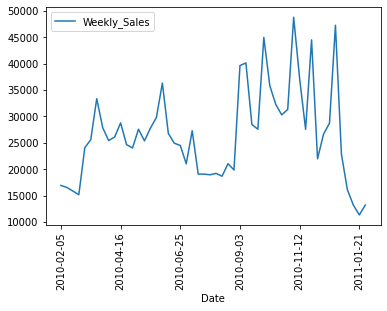

In [14]:
data_store1_dept9 = data_store1_dept9.sort_values('Date')
data_store1_dept9[['Date', 'Weekly_Sales']].iloc[:52]\
    .set_index('Date').plot(rot=90);

In [41]:
data_store1_dept9_2010 = data_store1_dept9[data_store1_dept9.Date < '2011-01-01']

In [45]:
data_store1_dept9_2010.sort_values('Weekly_Sales', ascending=False).head(6)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
1183,1,9,2010-11-05,"48,794.36",False,58.74,2.69,NaN,NaN,NaN,NaN,NaN,211.96,7.84,A,151315
1190,1,9,2010-12-24,"47,275.64",False,52.33,2.89,NaN,NaN,NaN,NaN,NaN,211.41,7.84,A,151315
1178,1,9,2010-10-01,"44,977.91",False,71.89,2.60,NaN,NaN,NaN,NaN,NaN,211.67,7.84,A,151315
1186,1,9,2010-11-26,"44,504.17",True,64.52,2.73,NaN,NaN,NaN,NaN,NaN,211.75,7.84,A,151315
1175,1,9,2010-09-10,"40,143.87",True,78.69,2.56,NaN,NaN,NaN,NaN,NaN,211.50,7.79,A,151315
1174,1,9,2010-09-03,"39,639.39",False,81.21,2.58,NaN,NaN,NaN,NaN,NaN,211.53,7.79,A,151315


Do you have any hypotheses about the holidays' impact on the sales?

#### Observations about holiday sales
* The sales are compounded weekly
* Not all the sales around holidays are `True` in the 'IsHoliday' column. This leads me to suspect that the column is only true for Federal holidays (but then why is Christmas Eve not recognized). I would need to examine 'IsHoliday' more to understand it.
* Largest sales are the around holidays (not necessarily corresponding to 'IsHoliday') and school dates.
 * Halloween tops the list - candy beats out Christmas gifts since they both have decorations and festive clothing (costumes or bad sweaters)
 * Christmas is next
 * I don't recognize what would correspond with the end of September. Maybe late back-to-school sales?
 * Turkey, stuffing, and decorations put Thanksgiving in the top four weeks.
 * The next two appear to be Labor Day and back-to-school (not sure about this date since there may be another back-to-school date).

**For the result of the notebook, we focus on the sales data from Store 1** in DataFrame `df` and is saved in `train_store1.csv`. Let's read in the data.

In [46]:
df = pd.read_csv("../dat/train-store1.csv")

Extract week, month, and year information from the raw `Date` column to better manipulate the weekly data later. Pandas comes with powerful features to make this step easy. Reference: [tutorial
](https://pandas.pydata.org/docs/getting_started/intro_tutorials/09_timeseries.html). 

First, use `.dtypes` to check the datatype of the `Date` column. What's the difference between `df[['Date']]` and `df['Date']`?.

In [48]:
# YOUR CODE 
print("[[]]", df[['Date']].dtypes)
print()
print("[]", df['Date'].dtypes)

[[]] Date    object
dtype: object

[] object


<details>
<summary>Expected Output</summary>
Date    object
dtype: object
</details>

In [49]:
df.Date=pd.to_datetime(df.Date)

Verify that the `Date` column's datatype has changed as expected:

In [50]:
df[['Date']].dtypes 

Date    datetime64[ns]
dtype: object

In [51]:
df['week'] = df.Date.dt.week
df['month'] = df.Date.dt.month 
df['year'] = df.Date.dt.year 

Verify that now there are 19 columns in `df`:

In [52]:
# YOUR CODE HERE
df.shape

(10244, 19)

Last step before we look deeper into the features is to split the data set into training and testing datasets. Discuss: why do we want to perform EDA only on the training data, not the entire dataset? Shouldn't it be the more the better?

We talked about needing to avoid overfitting and leakage in class. This was a little confusing and it wasn't clear at first how to overfit in EDA. The explaination that made the most sense to me was that we want our models and observations to be true for future data that we would not have, so only examining the training data allows the test data to act as artificial new data.

*The answer should mention data leakage, and / or overfitting*

Split the data into training (80%) and test dataset (20%). Use function `train_test_split` from `scikit-learn` ( a popular library for machine learning in Python ),  and set `random_state` to be 42 for reproducibility ( this is not the best way to do train-test-split due to the temporal nature of the data, however, we will ignore it for now ).

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
df_train, df_test =  train_test_split(df, test_size=0.2, random_state=42) # YOUR CODE HERE

In [55]:
print('Original set  ---> ',df.shape,
      '\nTraining set  ---> ',df_train.shape,
      '\nTesting set   ---> ', df_test.shape)

Original set  --->  (10244, 19) 
Training set  --->  (8195, 19) 
Testing set   --->  (2049, 19)


<details>
<summary>Expected Output</summary>

    ```
    Original set  --->  (10244, 19) 
    Training set  --->  (8195, 19) 
    Testing set   --->  (2049, 19)
    ```
</details>

## Task II: Target, Features, and Distributions

We inspect the datatype of column `Date`; now find datatypes for all columns in `df_train` using `.dtypes`:

In [57]:
# YOUR CODE HERE
df_train.dtypes 

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
week                     int64
month                    int64
year                     int64
dtype: object

<details>
<summary>Expected Output</summary>

```
Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
week                     int64
month                    int64
year                     int64
dtype: object
```
</details>

Summary statistics provide you with a general understanding of the data. Use method `.describe()`. By default it reports statistics mean, max, min, quantiles for numerical features and counts, unique, mode for categorical features.

In [59]:
pd.options.display.float_format = "{:,.2f}".format
# YOUR CODE HERE
df_train.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,week,month,year
count,"8,195.00","8,195.00","8,195.00","8,195.00","8,195.00","2,931.00","2,424.00","2,878.00","2,931.00","2,931.00","8,195.00","8,195.00","8,195.00","8,195.00","8,195.00","8,195.00"
mean,1.00,44.65,"21,865.28",68.19,3.22,"8,045.43","2,961.55","1,236.83","3,683.59","5,023.69",216.00,7.61,"151,315.00",25.89,6.47,"2,010.96"
std,0.00,29.95,"27,970.00",14.16,0.43,"6,484.49","8,032.30","7,830.99","5,849.69","3,303.07",4.33,0.38,0.00,14.19,3.25,0.80
min,1.00,1.00,-863.00,35.40,2.51,410.31,0.50,0.25,8.00,554.92,210.34,6.57,"151,315.00",1.00,1.00,"2,010.00"
25%,1.00,20.00,"3,502.09",57.79,2.76,"4,039.39",40.48,6.00,577.14,"3,127.88",211.57,7.35,"151,315.00",14.00,4.00,"2,010.00"
50%,1.00,38.00,"10,357.32",69.64,3.29,"6,154.14",137.86,30.23,"1,822.55","4,325.19",215.46,7.79,"151,315.00",26.00,6.00,"2,011.00"
75%,1.00,72.00,"31,647.36",80.48,3.59,"10,121.97","1,569.00",101.64,"3,639.42","6,222.25",220.64,7.84,"151,315.00",38.00,9.00,"2,012.00"
max,1.00,99.00,"203,670.47",91.65,3.91,"34,577.06","46,011.38","55,805.51","32,403.87","20,475.32",223.44,8.11,"151,315.00",52.00,12.00,"2,012.00"


<details>
<summary>Expected Output</summary>

```
	Store	Dept	Weekly_Sales	Temperature	Fuel_Price	MarkDown1	MarkDown2	MarkDown3	MarkDown4	MarkDown5	CPI	Unemployment	Size	week	month	year
count	8,195.00	8,195.00	8,195.00	8,195.00	8,195.00	2,931.00	2,424.00	2,878.00	2,931.00	2,931.00	8,195.00	8,195.00	8,195.00	8,195.00	8,195.00	8,195.00
mean	1.00	44.65	21,865.28	68.19	3.22	8,045.43	2,961.55	1,236.83	3,683.59	5,023.69	216.00	7.61	151,315.00	25.89	6.47	2,010.96
std	0.00	29.95	27,970.00	14.16	0.43	6,484.49	8,032.30	7,830.99	5,849.69	3,303.07	4.33	0.38	0.00	14.19	3.25	0.80
min	1.00	1.00	-863.00	35.40	2.51	410.31	0.50	0.25	8.00	554.92	210.34	6.57	151,315.00	1.00	1.00	2,010.00
25%	1.00	20.00	3,502.09	57.79	2.76	4,039.39	40.48	6.00	577.14	3,127.88	211.57	7.35	151,315.00	14.00	4.00	2,010.00
50%	1.00	38.00	10,357.32	69.64	3.29	6,154.14	137.86	30.23	1,822.55	4,325.19	215.46	7.79	151,315.00	26.00	6.00	2,011.00
75%	1.00	72.00	31,647.36	80.48	3.59	10,121.97	1,569.00	101.64	3,639.42	6,222.25	220.64	7.84	151,315.00	38.00	9.00	2,012.00
max	1.00	99.00	203,670.47	91.65	3.91	34,577.06	46,011.38	55,805.51	32,403.87	20,475.32	223.44	8.11	151,315.00	52.00	12.00	2,012.0
```
</details>

Inspect the output, what are some of your observations?

#### Observations:
* The training data looks like the initial examination of the data. Which is to be expected.

Are there any missing values? Use `.isna()` and `.sum()` to show the number of missing values from each column.

In [60]:
# YOUR CODE HERE
df_train.isna().sum()

Store              0
Dept               0
Date               0
Weekly_Sales       0
IsHoliday          0
Temperature        0
Fuel_Price         0
MarkDown1       5264
MarkDown2       5771
MarkDown3       5317
MarkDown4       5264
MarkDown5       5264
CPI                0
Unemployment       0
Type               0
Size               0
week               0
month              0
year               0
dtype: int64

<details>
<summary>Expected Output</summary>

```
Store              0
Dept               0
Date               0
Weekly_Sales       0
IsHoliday          0
Temperature        0
Fuel_Price         0
MarkDown1       5264
MarkDown2       5771
MarkDown3       5317
MarkDown4       5264
MarkDown5       5264
CPI                0
Unemployment       0
Type               0
Size               0
week               0
month              0
year               0
dtype: int64
```
</details>

What do you think the target variable is in this problem? Assign the column name to `target` for later use.

In [61]:
target = 'Weekly_Sales'

Visualize the distribution of target variable using `distplot()` from library `seaborn` ( Why seaborn? Check out a comparison between Matplotlib and Seaborn [here](https://analyticsindiamag.com/comparing-python-data-visualization-tools-matplotlib-vs-seaborn/) ). Anything here you observe but the output from `.describe` does not make obvious? Does it follow a normal distribution?

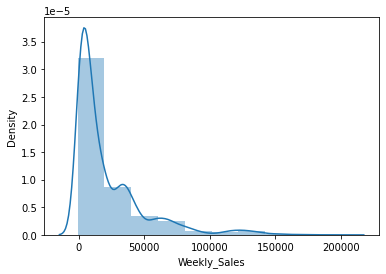

In [62]:
import seaborn as sns
sns.distplot(df_train[target],bins=10);

Notice that there exists nonpositive weekly sales. How many of rows are there that the weekly sales are negative or 0?

In [63]:
(df_train[target] <= 0).sum() # Expected Output: 13

13

What percentage is the negative and zero sales?

In [64]:
# YOUR CODE HERE
print((df_train[target] <= 0).sum()/(df_train[target].count()) *100, "%")
# Expected Output: 0.0015863331299572911 or 0.16%

0.1586333129957291 %


After communicating your findings, the stakeholders confirm that you can remove these data entries for now and they are launching an investigation by analysts and data engineers. 

Now remove them from the training dataset.

In [65]:
mask = df_train[target] > 0
df_train = df_train[mask]# YOUR CODE HERE
df_train.shape # Expected Output: (8182, 19)

(8182, 19)

Let's move on to features. 

Though almost all the features come as numerical, should they all be treated as numerical features? Let's inspect the number of unique values: 

In [66]:
[(col, df[col].nunique())for col in df_train.columns]

[('Store', 1),
 ('Dept', 77),
 ('Date', 143),
 ('Weekly_Sales', 10042),
 ('IsHoliday', 2),
 ('Temperature', 143),
 ('Fuel_Price', 137),
 ('MarkDown1', 51),
 ('MarkDown2', 41),
 ('MarkDown3', 49),
 ('MarkDown4', 51),
 ('MarkDown5', 51),
 ('CPI', 143),
 ('Unemployment', 12),
 ('Type', 1),
 ('Size', 1),
 ('week', 52),
 ('month', 12),
 ('year', 3)]

`Temperature`, `CPI`, `Unemployment`, `Fuel_Price` are continuous. Those tie to the second business objective. Let us put these four into a list and store it in `external_factors`. From earlier, we noticed that `MarkDownx` columns contain some missing values, we will treat them in a later task. 

In [67]:
external_factors = ['Temperature','CPI','Unemployment', 'Fuel_Price']

Visualize Temperature in a box plot, what do you think the adavange of a box plot over histogram? You can use `pd.DataFrame.boxplot()`, set the figure size as (6, 4), and turn off the grid.

[[Text(1, 0, '')]]

Text(0.5, 0, 'Temperature')

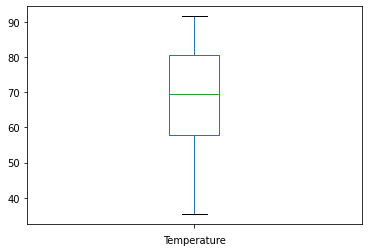

In [68]:
# YOUR CODE HERE
TempPlot = pd.DataFrame.boxplot(df.Temperature, figsize=(6,4), grid=False)
TempPlot.set(xticklabels=[])
TempPlot.set_xlabel('Temperature')

# reference for future
# https://stackoverflow.com/questions/58476654/how-to-remove-or-hide-x-axis-labels-from-a-seaborn-matplotlib-plot
# to get axis label correct

In [69]:
# Expected Output:

Let's visualize all four numerical features in both density plot and box plot. Note any observations.

                                 Numeric Features Distribution                                  


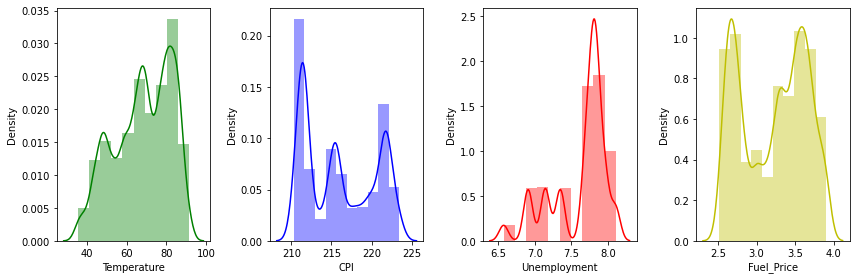

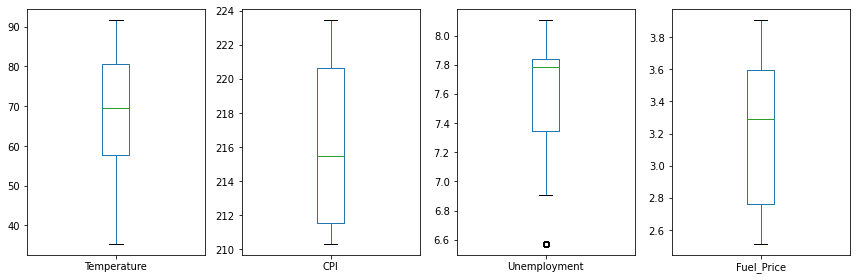

In [70]:
import matplotlib.pyplot as plt
print('\033[1mNumeric Features Distribution'.center(100))

figsize = (12, 4)

n=len(external_factors)
colors = ['g', 'b', 'r', 'y', 'k']

# histogram
plt.figure(figsize=figsize)
for i in range(len(external_factors)):
    plt.subplot(1,n,i+1)
    sns.distplot(df_train[external_factors[i]],
                 bins=10, 
                 color = colors[i])
plt.tight_layout();

# boxplot
plt.figure(figsize=figsize)
for i in range(len(external_factors)):
    plt.subplot(1,n,i+1)
    df_train.boxplot(external_factors[i], grid=False)
plt.tight_layout();

We will investigate the impacts from external factors later. Now let's scan through the other features.

`Store`, `Type`, and `Size` each has only one unique value, offering no information, we can safely ignore them. 

We extracted `year`, `month`, and `week` from  `Date`, thus `Date` is redundant; but it is easy to find the date range in the training dataset using `Date`:

In [71]:
df_train['Date'].min(), df_train['Date'].max() # Expected Output: (Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

(Timestamp('2010-02-05 00:00:00'), Timestamp('2012-10-26 00:00:00'))

Our training data ranges from 5th of February 2010 to 26th of October 2012.

It makes more sense to treat `year`, `month`, `week` as categorical, more accurately ordinal; and the boolean feature `IsHoliday` can be considered as categorical, so can `Dept`. Let's put these column names into a list `categoricalFeatures`.

In [72]:
categoricalFeatures = ['year','month','week','IsHoliday', 'Dept']

For the categorical features, we are more interested in the frequency of each value, use `pd.Series.value_counts` to see how many rows where `IsHoliday` is true and false respectively ( Data imbalance is the norm ).

In [73]:
# YOUR CODE HERE
pd.Series.value_counts(df_train.IsHoliday)

False    7586
True      596
Name: IsHoliday, dtype: int64

<details>
<summary>Expected Output</summary>

```
False    7586
True      596
Name: IsHoliday, dtype: int64
```
</details>

Visualize the distribution of `month`; use `sns.countplot()`.

<AxesSubplot:xlabel='month', ylabel='count'>

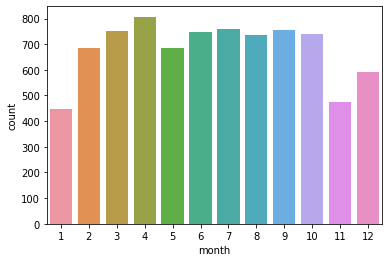

In [74]:
# YOUR CODE HERE
sns.countplot(df_train.month)

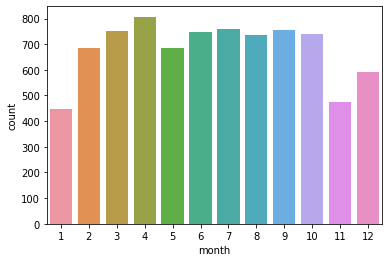

                               Visualising Categorical Features:                                


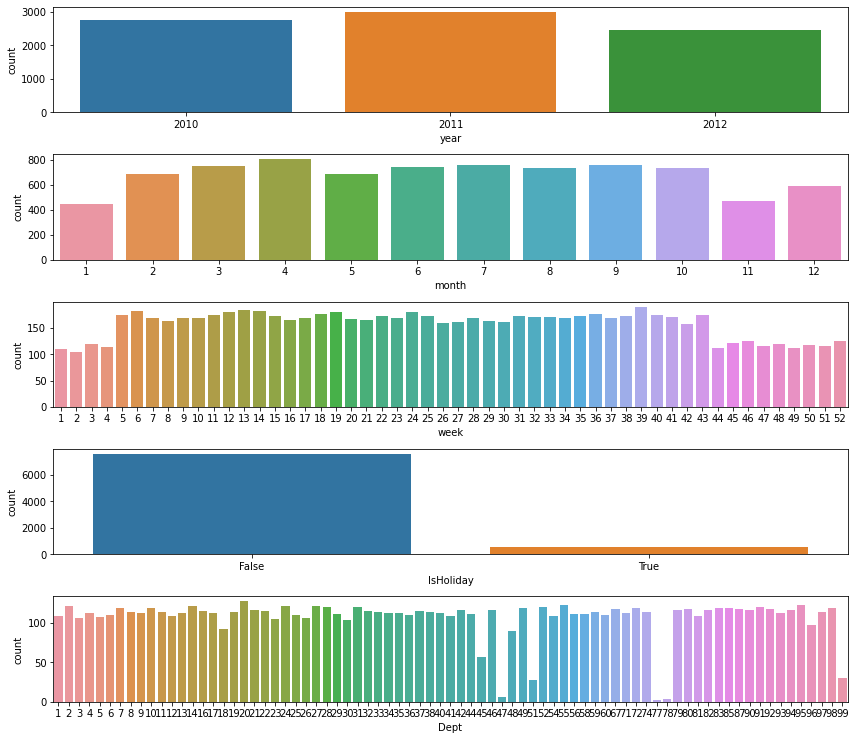

In [75]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(100))

plt.figure(figsize=(12,12))

for i in range(len(categoricalFeatures)):
    plt.subplot(6,1,i+1)
    sns.countplot(df_train[categoricalFeatures[i]])
plt.tight_layout();

Discuss with your teamate: there is less data in 2012 than the previous two years, did the sale drop from previous years? Does it affect what we see in the plots for month and week? Does the plot below clarify it to some degree?

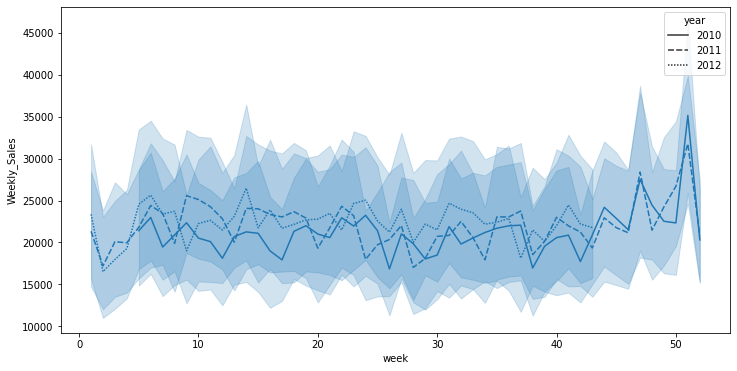

In [37]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_train, x="week", y="Weekly_Sales",  style='year');

## Task III: Impact from Holidays

The first business objective is to understand the impact of holidays on weekly sales. 

There is a flag provided for us: `IsHoliday`, let's calculate the average weekly sales for holiday weeks and non-holiday weeks, respectively. Use `.groupBy` and `.mean()`. Is holiday sales higher?

In [76]:
# YOUR CODE HERE
df_train.groupby(df_train.IsHoliday).mean()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,week,month,year
IsHoliday,,,,,,,,,,,,,,,,
False,1.00,44.57,"21,756.05",69.03,3.23,"8,186.49","1,784.09",112.88,"3,708.97","5,135.65",216.04,7.60,"151,315.00",25.40,6.36,"2,010.98"
True,1.00,45.78,"23,737.05",57.53,3.08,"6,357.82","13,911.05","13,879.62","3,370.34","3,767.50",215.48,7.73,"151,315.00",32.37,7.89,"2,010.79"


<details>
<summary>Expected Output</summary>

```
IsHoliday
False   21,756.05
True    23,737.05
Name: Weekly_Sales, dtype: float64
```
</details>


But we would like to understand it at more granular level, remember [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson's_paradox)? To save some time,  date mapping are identified for the training data

- Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12
- Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12
- Thanksgiving: 26-Nov-10, 25-Nov-11
- Christmas: 31-Dec-10, 30-Dec-11

We create one flag for each holiday to help you analyze weekly sale by each holiday type

In [77]:
superbowl_mask = df_train['Date'].isin(['2010-02-12', '2011-02-11', '2012-02-10'])
laborday_mask = df_train['Date'].isin(['2010-09-10', '2011-09-09','2012-09-07'])
thanksgiving_mask = df_train['Date'].isin(['2010-11-26', '2011-11-25'])
christmas_mask = df_train['Date'].isin(['2010-12-31', '2011-12-30'])

In [78]:
df_train['superbowl'] = superbowl_mask
df_train['laborday'] = laborday_mask
df_train['thanksgiving'] =thanksgiving_mask
df_train['christmas'] = christmas_mask

Run the next cell to see 1) how many weekly sales fell on Christmas (does it make sense? what did we not account for?) 2) what is the average weekly sales stratified by whether it is Christmas week or not?

##### Observations
1) I'm not sure what to make of the numbers. I don't think the Christmas mask is for the correct dates. In 2010 it appeared on 2010-12-24. I don't think we accounted for the pre-Christmas sales.
2) The average weekly sales appear to be less Christmas week (\$20.6k vs. \$21.9k). This may be due to the week actually being shorter by a day because most people do not shop on Christmas and many stores are closed on Christmas.

In [79]:
df_train.groupby(['christmas'])\
        .agg(count = ('christmas', 'size'), 
             avg_weekly_sales= ('Weekly_Sales','mean'))

,count,avg_weekly_sales
christmas,,
False,8057,"21,921.06"
True,125,"20,565.56"


Perform the same for the other three holidays:

In [82]:
holidays = ['superbowl', 'laborday', 'thanksgiving', 'christmas']
for holiday in holidays:
    summary_stats = df_train.groupby([holiday])\
            .agg(count = (holiday, 'size'),
                 avg_weekly_sales= ('Weekly_Sales','mean'))
    print(summary_stats)
    print()

           count  avg_weekly_sales
superbowl                         
False       8001         21,845.80
True         181         24,311.98

          count  avg_weekly_sales
laborday                         
False      8007         21,884.35
True        175         22,632.78

              count  avg_weekly_sales
thanksgiving                         
False          8067         21,813.97
True            115         27,959.84

           count  avg_weekly_sales
christmas                         
False       8057         21,921.06
True         125         20,565.56



<details>
<summary>Expected Output</summary>

```
           count  avg_weekly_sales
superbowl                         
False       8001         21,845.80
True         181         24,311.98

          count  avg_weekly_sales
laborday                         
False      8007         21,884.35
True        175         22,632.78

              count  avg_weekly_sales
thanksgiving                         
False          8067         21,813.97
True            115         27,959.84

           count  avg_weekly_sales
christmas                         
False       8057         21,921.06
True         125         20,565.56
```
</details>


Without hypothesis testing and by only eyeballing, it seems like Super Bowl and Thanksgiving has a positive impact on the weekly sales for Store 1 in this training dataset. 
Discuss with your teammate, are you surprised that during Christmas, sales at Walmart do not go up? Holiday effect, if causal, happened most during Thanksgiving weeks, is this something you expected?

#### Observations
It is not surprising to me that weekly sales do not appear to increase during Christmas week because:
* The week is shorter compared to the other holiday weeks - stores are generally closed and people do not shop on Christmas day. 
* Many purchases intended for Christmas happen earlier in the year (presents may be purchased on Black Friday, for instance).
* It is true that stores are closed for part of Thanksgiving day, but people do shop and sometimes Black Friday sales start on Thanksgiving day.
* Weeks with the Super Bowl and Labor Day have big events, big sales, and full weeks compared to Christmas week.

I would argue that the "Holiday effect" needs a better definition. The timeline for the effect is unclear (only the week, two week window before, two week straddle). Would the numbers tell a different story if we considered the number of days or hours in a week that the store was open? How many hours or days during the holiday week was the store closed?





We have been ignoring `Dept`, let's take a look at the plot below showing the weekly sales by department in 2011. 

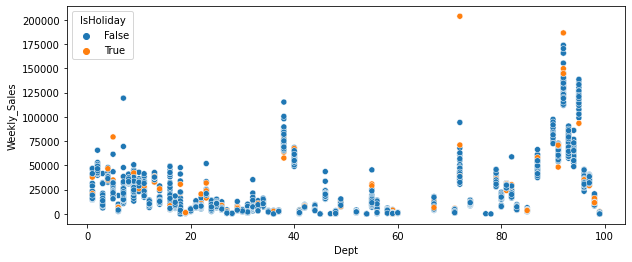

In [83]:
plt.figure(figsize=(10,4))
sns.scatterplot(data=df_train[df_train.year==2011], x = 'Dept', y= target, hue='IsHoliday');

Dept 72 has a very unusual high weekly sales during the holiday week, but we will need more data to understand if this is data issue, outlier, or special event. 

## Task IV: Visualize Relationship between Macroeconomic & External Factors and Sales

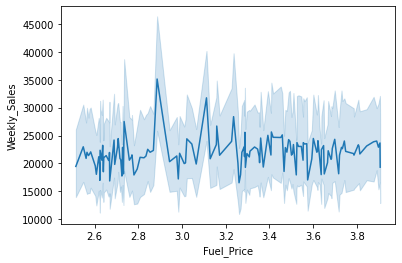

In [84]:
sns.lineplot(data=df_train, x="Fuel_Price", y="Weekly_Sales");

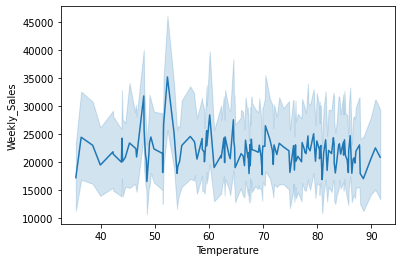

In [85]:
sns.lineplot(data=df_train, x="Temperature", y="Weekly_Sales");

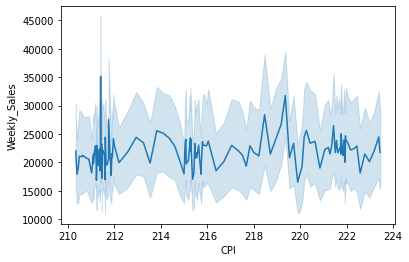

In [86]:
sns.lineplot(data=df_train, x="CPI", y="Weekly_Sales");

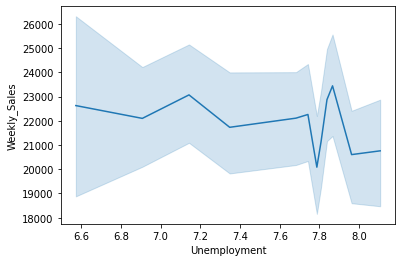

In [87]:
sns.lineplot(data=df_train, x="Unemployment", y="Weekly_Sales");

By eyeballing, do you find strong evidence that those are correlated with Walmart's weekly sales? Do you think `lineplot` is an appropriate plot for this?

### Observations:
* There appears to be a decrease in weekly sales as unemployment increases. There is a peak and dip around 7.8% unemployment that should be examined. The peaks in Temperature and Fuel_Price may warrant investigation, but there does not appear to be an overall trend.
* The confidence interval on `lineplot` helps to distinguish how much of the fluctuation is signal or noise. I would want a plot of the Weekly_Sales on the y-axis and the other variables on the x-axis. There may be another plot that would capture the confidence interval on a 2-d plot, but I'm happy with `lineplot`.

Lastly, we calculate the spearman correlations among target and external factors and verify that there is no strong linear correlation between the target variable and these features.

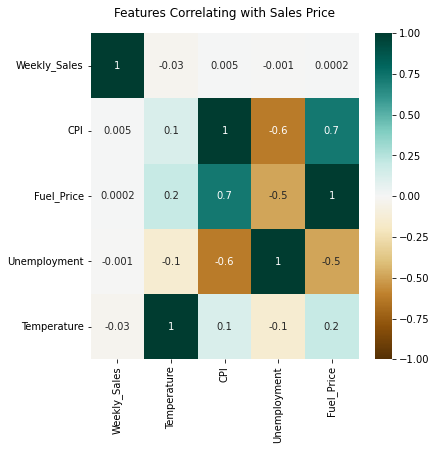

In [88]:
plt.figure(figsize=(6, 6))
df_train_reduced = df_train[[target] + external_factors]
corr = df_train_reduced.corr(method='spearman')
heatmap = sns.heatmap(corr.sort_values(by=target, ascending=False),
                      vmin=-1, vmax=1, annot=True, fmt='.1g', cmap='BrBG')
heatmap.set_title('Features Correlating with Sales Price', fontdict={'fontsize':12}, pad=16);

## Task V: Feature Engineering

"*Feature Engineering encapsulates various data engineering techniques such as selecting relevant features, handling missing data, encoding the data, and normalizing it. It is one of the most crucial tasks and plays a major role in determining the outcome of a model.*" [Ref](https://www.analyticsvidhya.com/blog/2021/10/a-beginners-guide-to-feature-engineering-everything-you-need-to-know/).

One part of feature engineering is to create new features from given data, like `thanksgiving` column earlier was derived from `Date`. Common techniques for tabular data include to add summary statistics of the numerical features such as mean and standard deviation, to create new features from the interaction of multiple features, etc. In this task, however, we will work on handling missing data, normalizing numerical features, and encoding categorical features. 

First, missing data. Missing value treatment is crucial, yet not trivial. Take a read on [Tackling Missing Value in Dataset](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/) for detailed explanation. Features with nulls or wrong values (e.g., negative fuel price) needs to be imputed or removed. 

- Do you want to keep the features with missing value? Discuss the trade offs
- If answer to the first question is yes, then how do you want to impute them? Discuss the trade offs

From ealier steps, we observed that only the markdown columns contain missing values, yet we do not have more information on what those values are for.  

In [89]:
df_train.columns[df_train.isna().sum() != 0]

Index(['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], dtype='object')

For each column, find out the percentage of the data is missing

In [103]:
md_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
for col in ['MarkDown'+str(i) for i in range(1,6)]:
    perc_missing =  df_train[col].isna().sum()/len(df_train[col]) # YOUR CODE HERE; perc_missing:float
    print(f'{col}: {perc_missing:.0%} is missing')

MarkDown1: 64% is missing
MarkDown2: 70% is missing
MarkDown3: 65% is missing
MarkDown4: 64% is missing
MarkDown5: 64% is missing


<details>
<summary>Expected Output</summary>

```
MarkDown1: 64% is missing
MarkDown2: 70% is missing
MarkDown3: 65% is missing
MarkDown4: 64% is missing
MarkDown5: 64% is missing
```
</details>


Marjority of the markdown fields are missing. This is where, again, we need to communicate with the stakeholders to understand what the data measure, how the data was collected and then determine our strategy from there. Here, for simplicity, we impute all missing values with median of the column. Use `.fillna()` to impute the missing values.

In [117]:
# YOUR CODE HERE # this works for smaller dataset
df_try = df_train
for col in ['MarkDown'+str(i) for i in range(1,6)]:
    perc_missing =  df_train[col].isna().sum()/len(df_train[col]) # YOUR CODE HERE; perc_missing:float
    df_train[col] = df_train[col].fillna(df_train[col].median())
    print(f'{col}: {perc_missing:.0%} is missing')
    print("col median: ", df_train[col].median())
    print("df_train NAs: ", (df_train.isna().sum() != 0).sum()) # sanity check: 0)

MarkDown1: 0% is missing
col median:  6154.14
df_train NAs:  0
MarkDown2: 0% is missing
col median:  137.86
df_train NAs:  0
MarkDown3: 0% is missing
col median:  30.23
df_train NAs:  0
MarkDown4: 0% is missing
col median:  1822.55
df_train NAs:  0
MarkDown5: 0% is missing
col median:  4325.19
df_train NAs:  0


In [118]:
(df_train.isna().sum() != 0).sum() # sanity check: 0

0

Visualize the distributions for those markdown fields after imputations, are they normal?

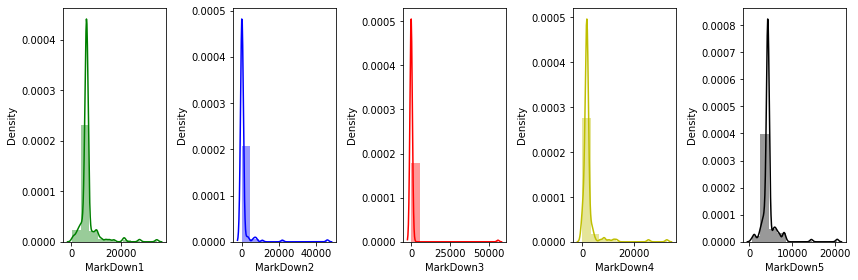

In [119]:
plt.figure(figsize=figsize)
for i in range(len(md_cols)):
    plt.subplot(1,len(md_cols),i+1)
    sns.distplot(df_train[md_cols[i]],
                 hist_kws=dict(linewidth=2),
                 bins=10, 
                 color = colors[i])
plt.tight_layout();

Note that missing values are different from outliers. Outliers, on the other hand, are feature values that are rare in nature. They can unncessarily skew the data and causes problem for modeling. Outlier treatment involves removing or imputing such values. One popular approach to identify outliers is IQR; that is, data points that lie 1.5 times of IQR above Q3 (third quartile) and below Q1 (first quartile) are outliers. Take a read on [Detecting and Treating Outliers](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/). We will leave it as an optional exercise for you to identify outliers using IQR, and replace the outliers with the median.

Now let's see how we normalize the data. For numerical features it means scaling the features to be of similar range. This step is crucial for machine learning algorithms that calculate distances between data (e.g., read [The Importance of Feature Scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html). 

For this task, of the external features, let's keep Temperature since it is the most linearly correlated with the target variable, though very weak and negative ( feature selection ). In addition, we include one markdown field. Since neither seems to follow normal distributions, it is safer to use `MinMaxScaler` from `sklearn.preprocessing` to transform features by scaling each feature to a given range (See discussion on [Normalization vs Standardization](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/))

In [55]:
from sklearn.preprocessing import MinMaxScaler

numericalFeatures = ['Temperature', 'MarkDown1']
df_train_num = df_train[numericalFeatures]

In [56]:
df_train_num.describe() # Check the summary statistics

,Temperature,MarkDown1
count,"8,182.00","8,182.00"
mean,68.19,"6,828.42"
std,14.16,"3,981.30"
min,35.40,410.31
25%,57.79,"6,154.14"
50%,69.64,"6,154.14"
75%,80.48,"6,154.14"
max,91.65,"34,577.06"


Instantiate a MinMaxScaler and fit using `df_train_num`:

In [57]:
scaler = # YOUR CODE HERE

Now transform training data `df_train_num` and store the resulting nparray in `train_norm`:

In [58]:
train_norm = scaler.transform(df_train_num) 

Verify that both columns now have minimum 0 and maximum 1. 

In [ ]:
pd.DataFrame(train_norm, columns=df_train_num.columns).describe()

In [59]:
# Expected Output:

,Temperature,MarkDown1
count,"8,182.00","8,182.00"
mean,0.58,0.19
std,0.25,0.12
min,0.00,0.00
25%,0.40,0.17
50%,0.61,0.17
75%,0.80,0.17
max,1.00,1.00


Let's turn to categorical fatures. So far most, if not all Python packages for modeling do not accept strings as input; thus encoding the categorical value to numerical value is a necessary step. Here, let's apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) on `Dept` and `IsHoliday`:

In [60]:
from sklearn.preprocessing import OneHotEncoder
categoricalFeatures = ['Dept', 'IsHoliday']
df_train_cat = df_train[categoricalFeatures]
ohe = OneHotEncoder(handle_unknown='ignore',sparse = False).fit(df_train_cat)

Transform the categorical features using one hote encoding `ohe`. 

In [61]:
train_ohe = # YOUR CODE HERE

In [ ]:
train_ohe.shape, df_train_cat.shape # Expected Output: ((8182, 79), (8182, 2))

The number of columns explodes from 2 to 79. 

Lastly we merge the processed numerical features with the processed categorical features using `hstack` in `numpy`:

In [63]:
import numpy as np
X_train = np.hstack([train_norm, train_ohe])

In [ ]:
X_train.shape # sanity check: (8182, 81)

What about the test data? Yes you need to apply the same treatments. We spare some copy + paste + edit and see how this can be done when we introduce `pipeline` next. 

## Task VI: Pipeline

Even with less than 20 features in our dataset, there are many many possibilities that you can preprocessing the data. There is no one-fits-all approach; often you will find yourself experimenting with many combinations to achieve better modelling performance: Should I apply normalization or standardization? Do I remove the outliers or should I impute them? Do I impute the missing values with median or mean or 0? Answers to many of these questions is "It depends." (Have you heard [Graduate Student Descent](https://sciencedryad.wordpress.com/2014/01/25/grad-student-descent/)?) That means trial-and-error and it is not efficient to produce a notebook each time when you need to try something slightly different. You will get lost quickly. Pipeline is one useful tool. 

Not only does Pipeline help streamline the process, keep the code modular, but also reduces the possibility of introducing errors/bugs. In this task, we build the pipeline following the strategies used in the last task, run a simple linear regression model, and print out the model's performance. Note there is minimal code required for you to implement, the key is to understand each step.

To avoid confusion, let's read the data again directly from `train-store1.csv`.

In [65]:
df = pd.read_csv('../dat/train-store1.csv')

In [66]:
df.shape

(10244, 16)

Separating the target `y` from the features `X`:

In [67]:
X, y = df.drop(columns=target), df[target]

Import `Pipeline` from submodule `sklearn.pipeline`

In [68]:
from sklearn.pipeline import Pipeline

Now we build a transformer for numerical features following two steps: impute the missing values with the feature median (use `SimpleImputer`), followed by normalization (use `MinMaxScaler`)

In [69]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
numeric_features = ['CPI', 'MarkDown1']
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), 
    # YOUR CODE HERE
])

For categorical features, we apply one hot encoding `OneHotEncoder` ( there are many other options; see [Scikit-learn documentation](https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) ):

In [70]:
categorical_features = ['Dept', 'IsHoliday']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

Piece the `numeric_transformer` and `categorical_transformer` using `ColumnTransformer`:

In [71]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

Lastly, let's append the regression model to preprocessing pipeline to complete a full prediction pipeline.

In [72]:
from sklearn.linear_model import LinearRegression

model = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LinearRegression())]
)

The pipepline has been built! The rest is to 
- split the data into training and testing sets
- apply the pipeline to the training data
- obtain the prediction performance on testing data

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's run the prediccction

In [75]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['CPI', 'MarkDown1']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Dept', 'IsHoliday'])])),
                ('model', LinearRegression())])

In [76]:
print("model score: %.3f" % model.score(X_test, y_test))

model score: 0.949


Optional: Discuss what type of [Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) strategy you would use to select the features.

## Note

- EDA, like other parts of machine learning, is an iterative process, NOT linear.
- This analysis is far from being comprehensive; rather it is a starting point. 
- There does not exist one "standard" way to perform EDA. You should always keep business objectives in mind and perform analysis as seen fit. It is one of those skills that grows with lots of practices.

## References

1. Original dataset is from [kaggle: wallmart sales forecast datasets](https://www.kaggle.com/datasets/iamprateek/wallmart-sales-forecast-datasets)
2. Notebook: [craking the walmart sales forecasting challenge](https://www.kaggle.com/code/fernandol/cracking-the-walmart-sales-forecasting-challenge)

## 3rd Deliverable:
1. Write down three lessons learned about exploratory data analysis, feature engineering, sales data modeling, or time-series data modeling.
2. Write down three lessons not yet learned about exploratory data analysis, feature engineering, sales data modeling, or time-series data modeling. 